# Products by departments

In [ ]:
import os
import shutil
import goes2go as g2g
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
# Define the start and end datetimes
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 1, 1)
num_days = (end_date - start_date).days
date_list = [start_date + timedelta(days=i) for i in range(num_days + 1)]
ImagesPath = "./GOESimages/"
product_list = { # ABI Products
"ABI-L2-ACMF": "Clear Sky Mask",
"ABI-L2-ACHAF": "Cloud Top Height",
"ABI-L2-ACHTF": "Cloud Top Temperature",
"ABI-L2-LSTF": "Land Surface Temperature",
}
# display(product_list)
from myfunctions.GOESfunctions import definingColormaps
colormaps = definingColormaps(False)
import geopandas as gpd
gdf_peru_land = gpd.read_file("./Boundaries/PER_adm/PER_adm1.shp")
department_names = sorted(gdf_peru_land['NAME_1'].tolist())
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

for product in list(product_list):
    os.makedirs(os.path.join(ImagesPath,"Departments",product), exist_ok=True)
    G = g2g.GOES(satellite=16, product=product)
    product_cmap = colormaps[product]
    for date_index, date in enumerate(date_list[:-1]):
        dsl = G.timerange(start=date_list[date_index], end=date_list[date_index+1], save_dir=ImagesPath, return_as = "filelist");
        # display.clear_output(wait=True)
        file_list = list(dsl['file'])
        for selected_file in file_list:
            # print("Working with file: ", selected_file)
            FullFilePath = os.path.join(ImagesPath,selected_file)
            rds = xr.open_dataset(FullFilePath, engine='rasterio')
            rds.close()
            rds_re = rds.rio.reproject("EPSG:4326")
            input_datetime = datetime.strptime(rds_re.attrs['date_created'], '%Y-%m-%dT%H:%M:%S.%fZ')
            output_date_string = input_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')
            day, month, year = output_date_string[8:10], output_date_string[5:7], output_date_string[:4]
            hour, minute, seconds = output_date_string[11:13], output_date_string[14:16], output_date_string[17:20]
            varname = list(rds_re.data_vars.keys())[0]
            data = rds_re[varname].isel(band=0)
            for department in department_names:
                outputs_directory = os.path.join(ImagesPath,"Departments",product, department)
                ImageName = '_'.join([product,department,year,month,day,hour,minute])
                FullImagePath = os.path.join(outputs_directory,ImageName+'.tif')
                os.makedirs(outputs_directory, exist_ok=True)
                polygon = gdf_peru_land[gdf_peru_land['NAME_1']==department]['geometry']
                data_clip = data.rio.clip(polygon)
                
                # fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
                # im = ax.contourf(data_clip.x,data_clip.y,data_clip.values,5,cmap=product_cmap)
                # plt.colorbar(im, label = data.attrs['long_name']+' ['+data.attrs['units']+']')
                # ax.set(title = 'Department: '+ department,
                    #    xlabel = "Longitude",
                    #    ylabel = "Latitude")
                # ax.add_geometries(polygon, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black')
                # ax.gridlines(draw_labels=True,lw=0.75,color='k',alpha=0.7,ls='--')
                
                # plt.savefig(FullImagePath,dpi=300,bbox_inches='tight')
                # plt.show()
                data_array = xr.DataArray(data_clip.values, coords=[data_clip.y, data_clip.x], dims=['latitude', 'longitude'])
                data_array.rio.write_crs("EPSG:4326")
                data_array.rio.to_raster(FullImagePath)
                
        print("Product "+product+"for "+date_list[date_index].strftime('%B')+" month processed.")
        parent_directory = os.path.join(ImagesPath,'noaa-goes16',product,str(date.year))
        subdirectories = [d for d in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, d))]
        date.year
        for subdirectory in subdirectories:
            subdirectory_path = os.path.join(parent_directory, subdirectory)
            try:
                shutil.rmtree(subdirectory_path)
                print(f"Directory '{subdirectory_path}' and its contents successfully removed.")
            except OSError as e:
                print(f"Error deleting '{subdirectory_path}': {e}")


# Products in a time range

In [3]:
#==================== We set product parameters to download ====================
import os
import goes2go as g2g
destination_path = '.\\GOESimages\\'
bucket = 'noaa-goes16'
product_list = { # ABI Products
# "ABI-L2-ACMF": "Clear Sky Mask",
# "ABI-L2-ACHAF": "Cloud Top Height",
# "ABI-L2-ACTPF": "Cloud Top Phase",
# "ABI-L2-ACHTF": "Cloud Top Temperature",
# "ABI-L2-LSTF": "Land Surface Temperature",
"ABI-L2-RRQPEF": "Rainfall rate",
# "ABI-L2-DSRF": "Downward Shortwave Radiation",
# "ABI-L2-DMWVF": "Derived Motion Winds - Vapor"
}
#==================== Setting up time reference variables ====================
from datetime import datetime, timedelta, timezone
import pytz
utc = pytz.timezone('UTC') # UTC timezone
utcm5 = pytz.timezone('America/Lima') # UTC-5 timezone
initial_date = utc.localize(datetime(2023,9,13,17)).astimezone(utc).replace(tzinfo=None)
final_date = utc.localize(datetime(2023,9,13,18)).astimezone(utc).replace(tzinfo=None)
from IPython.display import display, clear_output
# Set the time interval for clearing the output
time_interval = timedelta(hours=1)
start_time = datetime.now(utcm5)
from GOESutils.GOESplots import GeoColorPlot, ProductData, ProductPlot

for product in list(product_list):
    CurrentTime = datetime.now(utcm5)
    CurrentTime_str = CurrentTime.strftime('%Y-%m-%d %H:%M:%S %Z')
    print("============================================================")
    print("Current time is: {}".format(CurrentTime_str))
    prodFileList = g2g.data.goes_timerange(initial_date, final_date, satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
    print(f"There are {prodFileList.shape[0]} to be processed")
    for f in list(prodFileList['file']): 
        print("Working with file: {}".format(os.path.basename(f)))                
        FullFilePath = os.path.join(destination_path,f)
        rds_re, ProductParams = ProductData(FullFilePath, product)
        
        if os.path.exists(ProductParams["ImageFullPath"]):
            print("Image '{}' already exists in '{}'".format(ProductParams["ImageName"],ProductParams["ImagePath"]))
        else:
            file_datetime = ProductParams["ImgTime"].astimezone(utc)
            fig, ax = GeoColorPlot(destination_path, mode="timerange", file_datetime=file_datetime, toSave=True, toDisplay=False)
            if (not os.path.exists(ProductParams["ImagePath"])):
                print(f"Directory for product {product} does not exist. Creating new one...") 
                os.makedirs(ProductParams["ImagePath"])
            print(f"Image for file {os.path.basename(f)} not found, creating one...")
            figProd = ProductPlot(rds_re, product, ax, ProductParams, toSave=True)
            display(figProd)
            print("Image '{}' saved in '{}'".format(ProductParams["ImageName"], ProductParams["ImagePath"]))
    print("All the files have been processed.")
    
# Check if it's time to clear the output
CurrentTime = datetime.now(utcm5)
minute, seconds = CurrentTime.minute, CurrentTime.second
elapsed_time = CurrentTime - start_time
if elapsed_time >= time_interval:
    # Clear the output
    clear_output(wait=True)
    # Reset the start time
    start_time = datetime.now()

Current time is: 2023-09-22 17:49:48 -05
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-RRQPEF\2023\256\17\OR_ABI-L2-RRQPEF-M6_G16_s20232561700205_e20232561709513_c20232561709592.nc
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-RRQPEF\2023\256\17\OR_ABI-L2-RRQPEF-M6_G16_s20232561710205_e20232561719513_c20232561719594.nc
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-RRQPEF\2023\256\17\OR_ABI-L2-RRQPEF-M6_G16_s20232561730205_e20232561739513_c20232561739592.nc
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-RRQPEF\2023\256\17\OR_ABI-L2-RRQPEF-M6_G16_s20232561720205_e20232561729513_c20232561730006.nc
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-RRQPEF\2023\256\17\OR_ABI-L2-RRQPEF-M6_G16_s20232561740205_e20232561749513_c20232561749581.nc
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-RRQPEF\2023\256\17\OR_ABI-L2-RRQP

# Products in real time

c:\Users\germa\anaconda3\envs\satimg\Lib\site-packages\toolbox\cartopy_tools_OLD.py:37: UserWarning: Migrate to new `cartopy_tools` for latest updates and features.
  warnings.warn("Migrate to new `cartopy_tools` for latest updates and features.")
c:\Users\germa\anaconda3\envs\satimg\Lib\site-packages\toolbox\cartopy_tools_OLD.py:241: AccessorRegistrationWarning: registration of accessor <class 'toolbox.cartopy_tools_OLD.xr_to_cartopy'> under name 'xmap' for type <class 'xarray.core.dataset.Dataset'> is overriding a preexisting attribute with the same name.
  @xr.register_dataset_accessor("xmap")


Current time is: 2023-09-23 12:36:23 -05
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-MCMIPF\2023\266\17\OR_ABI-L2-MCMIPF-M6_G16_s20232661720205_e20232661729514_c20232661730005.nc
📦 Finished downloading [1] files to [GOESimages\noaa-goes16\ABI-L2-MCMIPF].
Getting latest available
Plotting 2023-09-23 12:25:05.950000-05:00 file as geocolor.
It is daytime! Plotting NaturalColor image...


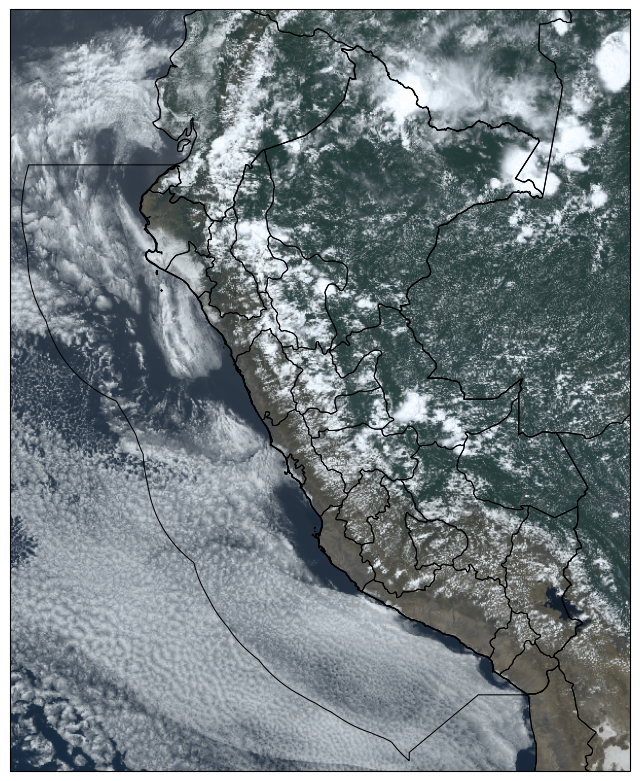

📦 Finished downloading [1] files to [GOESimages\noaa-goes16\ABI-L2-TPWF].
Getting latest available
Working with file: OR_ABI-L2-TPWF-M6_G16_s20232661720205_e20232661729514_c20232661731082.nc
Image for file OR_ABI-L2-TPWF-M6_G16_s20232661720205_e20232661729514_c20232661731082.nc not found, creating one...


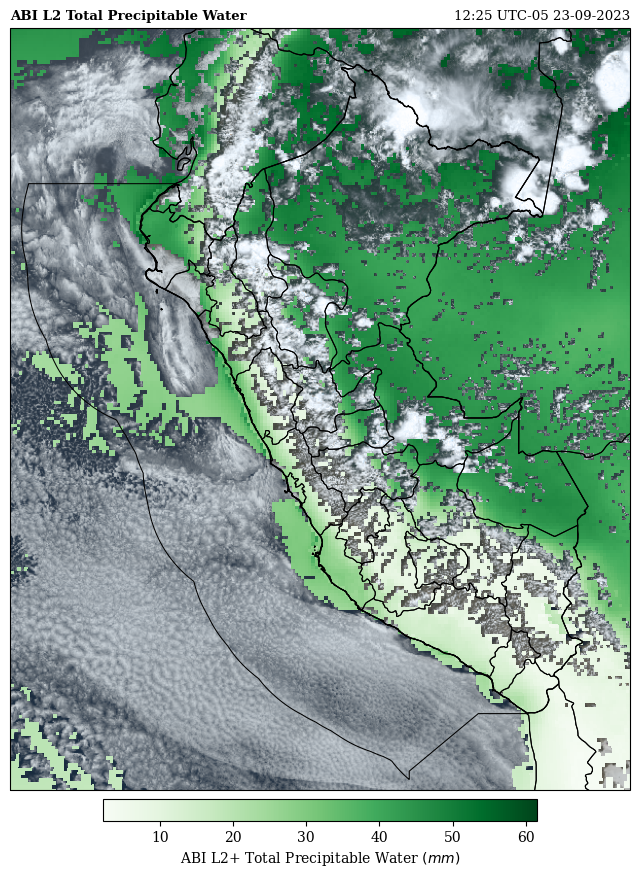

Image 'goes16_TPW_2023_09_23_12_25.png' saved in '.\GOESimages\Products\TPW'
All the files have been processed.
Waiting 3 minutes for the next file upload
Current time is: 2023-09-23 12:40:05 -05
 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-MCMIPF\2023\266\17\OR_ABI-L2-MCMIPF-M6_G16_s20232661720205_e20232661729514_c20232661730005.nc
📦 Finished downloading [1] files to [GOESimages\noaa-goes16\ABI-L2-MCMIPF].
Getting latest available
Plotting 2023-09-23 12:25:05.950000-05:00 file as geocolor.
It is daytime! Plotting NaturalColor image...


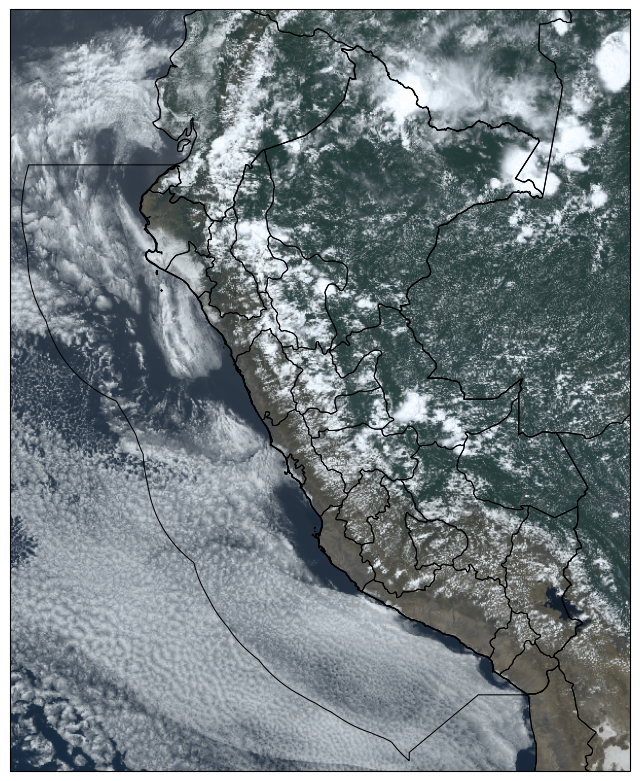

 👮🏻‍♂️ File already exists. Do not overwrite: GOESimages\noaa-goes16\ABI-L2-TPWF\2023\266\17\OR_ABI-L2-TPWF-M6_G16_s20232661720205_e20232661729514_c20232661731082.nc
📦 Finished downloading [1] files to [GOESimages\noaa-goes16\ABI-L2-TPWF].
Getting latest available
Working with file: OR_ABI-L2-TPWF-M6_G16_s20232661720205_e20232661729514_c20232661731082.nc
Image 'goes16_TPW_2023_09_23_12_25.png' already exists in '.\GOESimages\Products\TPW'
All the files have been processed.
Waiting 10 minutes for the next file upload
Current time is: 2023-09-23 12:50:39 -05
📦 Finished downloading [1] files to [GOESimages\noaa-goes16\ABI-L2-MCMIPF].
Getting latest available
Plotting 2023-09-23 12:35:05.900000-05:00 file as geocolor.
It is daytime! Plotting NaturalColor image...


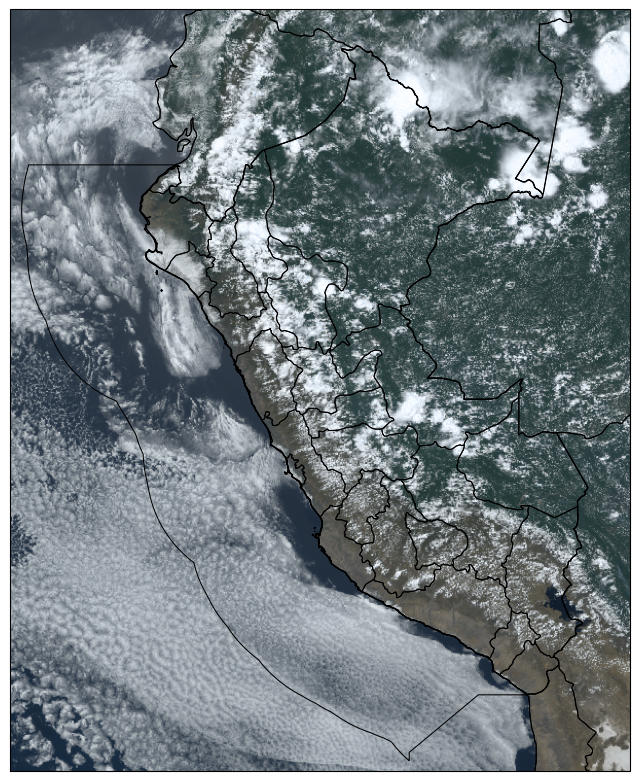

📦 Finished downloading [1] files to [GOESimages\noaa-goes16\ABI-L2-TPWF].
Getting latest available
Working with file: OR_ABI-L2-TPWF-M6_G16_s20232661730205_e20232661739514_c20232661741077.nc
Image for file OR_ABI-L2-TPWF-M6_G16_s20232661730205_e20232661739514_c20232661741077.nc not found, creating one...


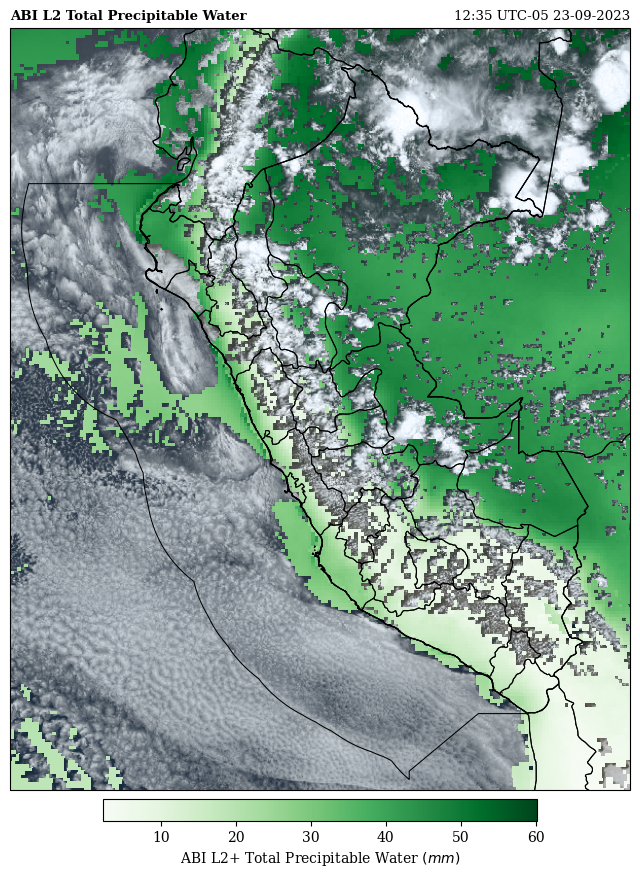

Image 'goes16_TPW_2023_09_23_12_35.png' saved in '.\GOESimages\Products\TPW'
All the files have been processed.
Waiting 9 minutes for the next file upload


In [1]:
#==================== We set product parameters to download ====================
import goes2go as g2g
destination_path = '.\\GOESimages\\'
bucket = 'noaa-goes16'
product_list = { # ABI Products
# "ABI-L2-ACMF": "Clear Sky Mask",
"ABI-L2-ACHAF": "Cloud Top Height",
"ABI-L2-ACTPF": "Cloud Top Phase",
# "ABI-L2-ACHTF": "Cloud Top Temperature",
# "ABI-L2-LSTF": "Land Surface Temperature",
"ABI-L2-RRQPEF": "Rainfall rate",
# "ABI-L2-DSRF": "Downward Shortwave Radiation",
# "ABI-L2-DMWVF": "Derived Motion Winds - Vapor",
"ABI-L2-TPWF": "Total Precipitable Water",
}
#==================== Setting up time reference variables ====================
from datetime import datetime, timedelta, timezone
import os, pytz, time, requests
utc = pytz.timezone('UTC') # UTC timezone
utcm5 = pytz.timezone('America/Lima') # UTC-5 timezone
initial_date = datetime(2023,9,1)
final_date = datetime.now()
from IPython.display import display, clear_output
# Set the time interval for clearing the output
time_interval = timedelta(minutes=30)
start_time = datetime.now(utcm5)
from GOESutils.GOESplots import GeoColorPlot, ProductData, ProductPlot

while True:
    CurrentTime = datetime.now(utcm5)
    CurrentTime_str = CurrentTime.strftime('%Y-%m-%d %H:%M:%S %Z')
    print("============================================================")
    print("Current time is: {}".format(CurrentTime_str))
    fig, ax = GeoColorPlot(destination_path, toSave=True)
    try:
        res = requests.get("https://www.google.com/")
        if res.status_code == 200:
            for product in list(product_list):
                try: 
                    prodFileList = g2g.data.goes_latest(satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
                    print("Getting latest available")
                except ValueError:
                    try:
                        CurrentTime = utc.localize(datetime.now()).replace(tzinfo=None)
                        prodFileList = g2g.data.goes_nearesttime(CurrentTime, satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
                        print("Getting nearest available")
                    except ValueError:
                        CurrentTime = utc.localize(datetime.now()).replace(tzinfo=None) - timedelta(hours=1)
                        prodFileList = g2g.data.goes_nearesttime(CurrentTime, satellite=bucket, product=product, domain='F', download=True, save_dir=destination_path, return_as='filelist')
                        print("Getting nearest available 1 hour before")
                # old_files = os.listdir(ImgPath)
                # old_png_files = set([file for file in old_files if file.endswith('.png')])
                # are_there_old_filenames = (len(old_png_files) > 0)
                
                for f in list(prodFileList['file']): 
                    print("Working with file: {}".format(os.path.basename(f)))                
                    FullFilePath = os.path.join(destination_path,f)
                    rds_re, ProductParams = ProductData(FullFilePath, product)
                    if os.path.exists(ProductParams["ImageFullPath"]):
                        print("Image '{}' already exists in '{}'".format(ProductParams["ImageName"],ProductParams["ImagePath"]))
                    else:
                        if (not os.path.exists(ProductParams["ImagePath"])):
                            print(f"Directory for product {product} does not exist. Creating new one...") 
                            os.makedirs(ProductParams["ImagePath"])
                        print(f"Image for file {os.path.basename(f)} not found, creating one...")
                        figProd = ProductPlot(rds_re, product, ax, ProductParams, toSave=True)
                        display(figProd)
                        print("Image '{}' saved in '{}'".format(ProductParams["ImageName"], ProductParams["ImagePath"]))
                print("All the files have been processed.")
    except Exception as e:
        print(f"Se perdio la conexion a internet..{e}")
        print(f"Waiting 30 seconds for internet connection.")
        time.sleep(30)
        
    # Check if it's time to clear the output
    try:
        CurrentTime = datetime.now(utcm5)
        minute, seconds = CurrentTime.minute, CurrentTime.second
        elapsed_time = CurrentTime - start_time
        if elapsed_time >= time_interval:
            # Clear the output
            clear_output(wait=True)
            # Reset the start time
            start_time = datetime.now(utcm5)
            
        total_remaining_seconds = (10 - (int(minute) % 10)) * 60 - int(seconds)
        remaining_minutes = total_remaining_seconds // 60
        print("Waiting {} minutes for the next file upload".format(remaining_minutes + 1))
        time.sleep((remaining_minutes+1)*60)
    except Exception as e:
        print("Elapsed time attempting failed.")